In [1]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

# Get a handle to the workspace. You can find the info on the workspace tab on ml.azure.com
ml_client = MLClient(
    credential=credential,
    subscription_id="8a57ea7c-2d6f-4699-b47b-32044893afd5",  # this will look like xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx
    resource_group_name="vamshivardhankodidala-rg",
    workspace_name="mlops",
)

In [2]:
pip install tensorrt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import matplotlib.pyplot as plt
import numpy as np
import json
import platform
import time
import pathlib
import os
import csv
import json

2023-05-29 07:56:55.822132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 07:57:07.444574: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-29 07:57:07.444836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-29 07:57:07.444848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [6]:
#dataset_raw = load_dataset() 

In [7]:
from csv import DictReader
# open file in read mode
with open("RAW_recipes_new.csv", 'r',encoding='utf-8') as f:
     
    dict_reader = DictReader(f)
     
    dataset = list(dict_reader)
   
print(dataset[0])

{'id': '1', 'title': 'arriba   baked winter squash mexican style', 'ingredients': 'winter squash, mexican seasoning, mixed spice, honey, butter, olive oil, salt', 'instructions': 'make a choice and proceed with recipe, depending on size of squash , cut into half or fourths, remove seeds, for spicy squash , drizzle olive oil or melted butter over each cut squash piece, season with mexican seasoning mix ii, for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece, season with sweet mexican spice mix, bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin, be careful not to burn the squash especially if you opt to use sugar or butter, if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking, if desired , season with salt'}


In [8]:
print('Total number of raw examples: ', len(dataset))

Total number of raw examples:  140850


In [9]:
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [10]:
dataset_validated = [recipe for recipe in dataset if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of incomplete recipes', len(dataset) - len(dataset_validated))

Dataset size BEFORE validation 140850
Dataset size AFTER validation 140849
Number of incomplete recipes 1


In [11]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

In [12]:
print(dataset_validated[0])

{'id': '1', 'title': 'arriba   baked winter squash mexican style', 'ingredients': 'winter squash, mexican seasoning, mixed spice, honey, butter, olive oil, salt', 'instructions': 'make a choice and proceed with recipe, depending on size of squash , cut into half or fourths, remove seeds, for spicy squash , drizzle olive oil or melted butter over each cut squash piece, season with mexican seasoning mix ii, for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece, season with sweet mexican spice mix, bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin, be careful not to burn the squash especially if you opt to use sugar or butter, if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking, if desired , season with salt'}


In [13]:
def recipe_to_string(recipe):
    # This string is presented as a part of recipes so we need to clean it up.
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients'].split(',')
    instructions = recipe['instructions'].split(',')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'    # adding bullets to structure the data
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'    # adding bullets to structure the data
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'


In [14]:
print(recipe_to_string(dataset_validated[0]))

📗 arriba   baked winter squash mexican style

🥕

• winter squash
•  mexican seasoning
•  mixed spice
•  honey
•  butter
•  olive oil
•  salt

📝

▪︎ make a choice and proceed with recipe
▪︎  depending on size of squash 
▪︎  cut into half or fourths
▪︎  remove seeds
▪︎  for spicy squash 
▪︎  drizzle olive oil or melted butter over each cut squash piece
▪︎  season with mexican seasoning mix ii
▪︎  for sweet squash 
▪︎  drizzle melted honey 
▪︎  butter 
▪︎  grated piloncillo over each cut squash piece
▪︎  season with sweet mexican spice mix
▪︎  bake at 350 degrees 
▪︎  again depending on size 
▪︎  for 40 minutes up to an hour 
▪︎  until a fork can easily pierce the skin
▪︎  be careful not to burn the squash especially if you opt to use sugar or butter
▪︎  if you feel more comfortable 
▪︎  cover the squash with aluminum foil the first half hour 
▪︎  give or take 
▪︎  of baking
▪︎  if desired 
▪︎  season with salt



In [15]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]
print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  140849


In [16]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 arriba   baked winter squash mexican style

🥕

• winter squash
•  mexican seasoning
•  mixed spice
•  honey
•  butter
•  olive oil
•  salt

📝

▪︎ make a choice and proceed with recipe
▪︎  depending on size of squash 
▪︎  cut into half or fourths
▪︎  remove seeds
▪︎  for spicy squash 
▪︎  drizzle olive oil or melted butter over each cut squash piece
▪︎  season with mexican seasoning mix ii
▪︎  for sweet squash 
▪︎  drizzle melted honey 
▪︎  butter 
▪︎  grated piloncillo over each cut squash piece
▪︎  season with sweet mexican spice mix
▪︎  bake at 350 degrees 
▪︎  again depending on size 
▪︎  for 40 minutes up to an hour 
▪︎  until a fork can easily pierce the skin
▪︎  be careful not to burn the squash especially if you opt to use sugar or butter
▪︎  if you feel more comfortable 
▪︎  cover the squash with aluminum foil the first half hour 
▪︎  give or take 
▪︎  of baking
▪︎  if desired 
▪︎  season with salt



Recipe #2
---------
📗 a bit different  breakfast pizza


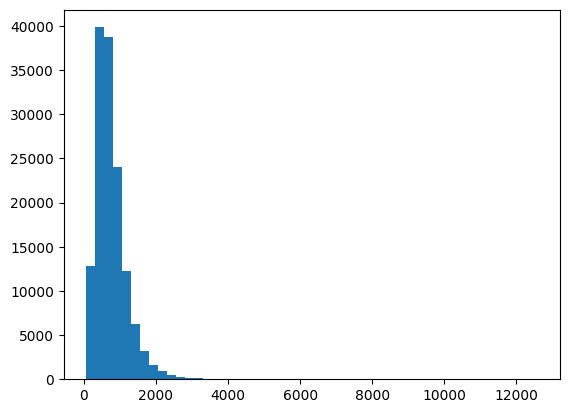

In [17]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

plt.hist(recipes_lengths, bins=50)
plt.show()

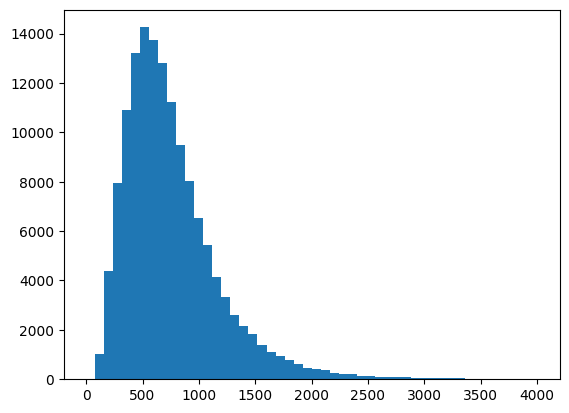

In [18]:
plt.hist(recipes_lengths, range=(0, 4000), bins=50)
plt.show()

In [19]:
MAX_RECIPE_LENGTH = 800

def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of eliminated recipes: ', len(dataset_stringified) - len(dataset_filtered)) 

Dataset size BEFORE filtering:  140849
Dataset size AFTER filtering:  89614
Number of eliminated recipes:  51235


In [20]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  800
TOTAL_RECIPES_NUM:  89614


In [21]:
STOP_SIGN = '␣'

tokenizer = tf.keras.preprocessing.text.Tokenizer()

# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

tokenizer.fit_on_texts(dataset_filtered)

tokenizer.get_config()

{'num_words': None,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 89615,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 89614, "a": 130634, "bit": 1242, "different": 246, "breakfast": 918, "pizza": 1969, "\\ud83e\\udd55": 89614, "\\u2022": 693944, "prepared": 3676, "crust": 4372, "sausage": 3601, "patty": 278, "eggs": 22052, "milk": 30578, "salt": 68810, "and": 298127, "pepper": 60234, "cheese": 57007, "\\ud83d\\udcdd": 89614, "\\u25aa\\ufe0e": 886645, "preheat": 13001, "oven": 25660, "to": 120640, "425": 961, "degrees": 12470, "f": 3349, "press": 3058, "dough": 5952, "into": 47192, "the": 185813, "bottom": 4783, "sides": 4302, "of": 63043, "12": 4352, "inch": 10193, "pan": 28712, "bake": 32087, "for": 74741, "5": 15021, "minutes": 71193, "until": 85537, "set": 10315, "but": 4303, "not": 5973, "browned": 4703, "cut": 13252, "small": 11796, "pieces": 6130, "whisk": 6486, "in": 161303, "b

In [22]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  30052


In [23]:
for i in range(1,75):
  print(tokenizer.index_word[i],end=" ")

▪︎ • and the in a to with 📗 🥕 📝 until add for minutes salt of pepper sugar cheese or butter mix on into oil heat chicken over cream 1 garlic stir onion water sauce bowl ingredients cook flour 2 bake mixture baking milk place combine juice pan serve brown all oven powder pour well at fresh lemon top is large eggs ground medium egg cover together about vanilla green olive then sprinkle 

In [24]:
tokenizer.word_index['o']

1061

In [25]:
array_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in array_vocabulary])

['', '▪︎', '•', 'and', 'the', 'in', 'a', 'to', 'with', '📗', '🥕', '📝', 'until', 'add', 'for', 'minutes', 'salt', 'of', 'pepper', 'sugar', 'cheese', 'or', 'butter', 'mix', 'on', 'into', 'oil', 'heat', 'chicken', 'over', 'cream', '1', 'garlic', 'stir', 'onion', 'water', 'sauce', 'bowl', 'ingredients', 'cook', 'flour', '2', 'bake', 'mixture', 'baking', 'milk', 'place', 'combine', 'juice', 'pan', 'serve', 'brown', 'all', 'oven', 'powder', 'pour', 'well', 'at', 'fresh', 'lemon', 'top', 'is', 'large', 'eggs', 'ground', 'medium', 'egg', 'cover', 'together', 'about', 'vanilla', 'green', 'olive', 'then', 'sprinkle', 'chocolate', 'bread', 'remove', '4', '3', 'hot', 'onions', 'from', 'low', 'tomatoes', 'cool', '5', 'potatoes', 'it', 'beef', 'boil', 'rice', 'red', '10', 'soup', 'cinnamon', 'black', 'each', 'cut', 'dish', 'remaining', 'preheat', 'hours', 'if', 'degrees', 'vinegar', '350', 'dry', 'beans', 'simmer', 'salad', 'small', 'are', 'half', 'skillet', 'stirring', 'drain', 'white', 'you', '30',

In [26]:
tokenizer.texts_to_sequences(['📗 yes'])

[[9, 3679]]

In [27]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

print('Vectorized dataset size', len(dataset_vectorized)) 

Vectorized dataset size 89614


In [28]:
dataset_vectorized[0]

[9,
 6,
 718,
 1628,
 841,
 527,
 10,
 2,
 336,
 527,
 287,
 2,
 339,
 1521,
 2,
 63,
 2,
 45,
 2,
 16,
 3,
 18,
 2,
 20,
 11,
 1,
 101,
 53,
 7,
 823,
 104,
 360,
 1,
 394,
 221,
 25,
 4,
 260,
 3,
 293,
 17,
 6,
 289,
 133,
 527,
 49,
 1,
 42,
 14,
 86,
 15,
 12,
 130,
 292,
 220,
 267,
 1,
 98,
 339,
 25,
 111,
 216,
 1,
 200,
 63,
 3,
 45,
 5,
 6,
 37,
 12,
 1334,
 1,
 180,
 339,
 29,
 356,
 287,
 3,
 74,
 8,
 20,
 1,
 55,
 66,
 43,
 476,
 29,
 339,
 3,
 20,
 1,
 150,
 2341,
 7,
 191,
 1,
 42,
 126,
 139,
 15,
 21,
 12,
 63,
 112,
 130,
 3,
 287,
 61,
 51]

In [29]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    print(recipe_stringified)

recipe_sequence_to_string(dataset_vectorized[0])

📗 a bit different breakfast pizza 🥕 • prepared pizza crust • sausage patty • eggs • milk • salt and pepper • cheese 📝 ▪︎ preheat oven to 425 degrees f ▪︎ press dough into the bottom and sides of a 12 inch pizza pan ▪︎ bake for 5 minutes until set but not browned ▪︎ cut sausage into small pieces ▪︎ whisk eggs and milk in a bowl until frothy ▪︎ spoon sausage over baked crust and sprinkle with cheese ▪︎ pour egg mixture slowly over sausage and cheese ▪︎ s p to taste ▪︎ bake 15 20 minutes or until eggs are set and crust is brown


In [30]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 110
Recipe #2 length: 107
Recipe #3 length: 91
Recipe #4 length: 42
Recipe #5 length: 69
Recipe #6 length: 117
Recipe #7 length: 149
Recipe #8 length: 38
Recipe #9 length: 85
Recipe #10 length: 95


In [31]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all recipes will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
print(dataset_vectorized_padded_without_stops[0][:15])

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
print(dataset_vectorized_padded[0][:17])

for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

[   9    6  718 1628  841  527   10    2  336  527  287    2  339 1521
    2]
[   9    6  718 1628  841  527   10    2  336  527  287    2  339 1521
    2   63    2]
Recipe #0 length: 801
Recipe #1 length: 801
Recipe #2 length: 801
Recipe #3 length: 801
Recipe #4 length: 801
Recipe #5 length: 801
Recipe #6 length: 801
Recipe #7 length: 801
Recipe #8 length: 801
Recipe #9 length: 801


In [32]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗 a bit different breakfast pizza 🥕 • prepared pizza crust • sausage patty • eggs • milk • salt and pepper • cheese 📝 ▪︎ preheat oven to 425 degrees f ▪︎ press dough into the bottom and sides of a 12 inch pizza pan ▪︎ bake for 5 minutes until set but not browned ▪︎ cut sausage into small pieces ▪︎ whisk eggs and milk in a bowl until frothy ▪︎ spoon sausage over baked crust and sprinkle with cheese ▪︎ pour egg mixture slowly over sausage and cheese ▪︎ s p to taste ▪︎ bake 15 20 minutes or until eggs are set and crust is brown ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣

In [33]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [34]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset element_spec=TensorSpec(shape=(801,), dtype=tf.int32, name=None)>


In [35]:
for recipe in dataset.take(3):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [    9     6   718  1628   841   527    10     2   336   527   287     2
   339  1521     2    63     2    45     2    16     3    18     2    20
    11     1   101    53     7   823   104   360     1   394   221    25
     4   260     3   293    17     6   289   133   527    49     1    42
    14    86    15    12   130   292   220   267     1    98   339    25
   111   216     1   200    63     3    45     5     6    37    12  1334
     1   180   339    29   356   287     3    74     8    20     1    55
    66    43   476    29   339     3    20     1   150  2341     7   191
     1    42   126   139    15    21    12    63   112   130     3   287
    61    51 15429 15429 15429 15429 15429 15429 15429 15429 15429 15429
 15429 15429 15429 15429 15429 15429 15429 15429 15429 15429 15429 15429
 15429 15429 15429 15429 15429 15429 15429 15429 15429 15429 15429 15429
 15429 15429 15429 15429 15429 15429 15429 15429 15429 15429 15429 15429
 15429 15429 15429 15429 15429 15429 1

In [36]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset element_spec=(TensorSpec(shape=(800,), dtype=tf.int32, name=None), TensorSpec(shape=(800,), dtype=tf.int32, name=None))>


In [37]:
for input_example, target_example in dataset_targeted.take(3):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified))) 

Input sequence size: 800
Target sequence size: 800

Input:   '📗 a bit different breakfast pizza 🥕 • prepared pizza crust • sausage patty • eggs • milk • salt and pepper • cheese 📝 ▪︎ preheat oven to 425 degrees f ▪︎ press dough into the bottom and sides of a 12 inch pizza pan ▪︎ bake for 5'
Target:  'a bit different breakfast pizza 🥕 • prepared pizza crust • sausage patty • eggs • milk • salt and pepper • cheese 📝 ▪︎ preheat oven to 425 degrees f ▪︎ press dough into the bottom and sides of a 12 inch pizza pan ▪︎ bake for 5 minutes'
Input sequence size: 800
Target sequence size: 800

Input:   '📗 all in the kitchen chili 🥕 • ground beef • yellow onions • diced tomatoes • tomato paste • tomato soup • rotel tomatoes • kidney beans • water • chili powder • ground cumin • salt • lettuce • cheddar cheese 📝 ▪︎ brown ground beef in large'
Target:  'all in the kitchen chili 🥕 • ground beef • yellow onions • diced tomatoes • tomato paste • tomato soup • rotel tomatoes • kidney beans • water • chi

In [38]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 9 ('📗')
  expected output: 2157 ('amish')
Step  2
  input: 2157 ('amish')
  expected output: 136 ('tomato')
Step  3
  input: 136 ('tomato')
  expected output: 438 ('ketchup')
Step  4
  input: 438 ('ketchup')
  expected output: 14 ('for')
Step  5
  input: 14 ('for')
  expected output: 1908 ('canning')
Step  6
  input: 1908 ('canning')
  expected output: 10 ('🥕')
Step  7
  input: 10 ('🥕')
  expected output: 2 ('•')
Step  8
  input: 2 ('•')
  expected output: 136 ('tomato')
Step  9
  input: 136 ('tomato')
  expected output: 48 ('juice')
Step 10
  input: 48 ('juice')
  expected output: 2 ('•')


In [39]:
print(dataset_targeted)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

<MapDataset element_spec=(TensorSpec(shape=(800,), dtype=tf.int32, name=None), TensorSpec(shape=(800,), dtype=tf.int32, name=None))>
TOTAL_RECIPES_NUM:  89614
MAX_RECIPE_LENGTH:  800
VOCABULARY_SIZE:  30052


In [40]:
# Batch size.
BATCH_SIZE = 16

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat() 
  # \
  # Shuffling examples first. \
  # Splitting examples on batches. \
  # Making a dataset to be repeatable (it will never ends). 
  

print(dataset_train)

<RepeatDataset element_spec=(TensorSpec(shape=(16, 800), dtype=tf.int32, name=None), TensorSpec(shape=(16, 800), dtype=tf.int32, name=None))>


In [41]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[    9   494  1929 ... 15429 15429 15429]
 [    9  4136  1737 ... 15429 15429 15429]
 [    9    79    21 ... 15429 15429 15429]
 ...
 [    9   119   214 ... 15429 15429 15429]
 [    9    79  8936 ... 15429 15429 15429]
 [    9 11812   798 ... 15429 15429 15429]], shape=(16, 800), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  494  1929   917 ... 15429 15429 15429]
 [ 4136  1737    10 ... 15429 15429 15429]
 [   79    21    78 ... 15429 15429 15429]
 ...
 [  119   214    30 ... 15429 15429 15429]
 [   79  8936  1012 ... 15429 15429 15429]
 [11812   798  2360 ... 15429 15429 15429]], shape=(16, 800), dtype=int32)


In [42]:
tmp_vocab_size = 10
tmp_embedding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embedding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

1/1 [==============================] - 0s 222ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[3 3 8 6 4 3 7 1]
 [0 8 9 1 1 3 5 1]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.03517259  0.03469667 -0.01921445 -0.01253986  0.02500627]
  [ 0.03517259  0.03469667 -0.01921445 -0.01253986  0.02500627]
  [ 0.04983505 -0.04498003 -0.02912703 -0.00134631 -0.01975198]
  [ 0.03819757 -0.02366818 -0.01834577  0.02612517 -0.02998604]
  [-0.00186492  0.03465655 -0.04063182  0.0340107   0.02485437]
  [ 0.03517259  0.03469667 -0.01921445 -0.01253986  0.02500627]
  [-0.00989311  0.04357095 -0.00854133 -0.04984803  0.01347467]
  [ 0.01290094  0.03385722 -0.03842969 -0.01789187  0.02171084]]

 [[ 0.00980483  0.03545668 -0.03868672  0.03034895 -0.00190274]
  [ 0.04983505 -0.04498003 -0.02912703 -0.00134631 -0.01975198]
  [-0.00567456  0.04378543  0.04831049  0.00595172  0.03425524]
  [ 0.01290094  0.03385722 -0.03842969 -0.01789187  0.02171084]
  [ 0.01290094  0.03385722 -0.03842969

In [43]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import backend as K
import tensorflow as tf
tf.compat.v1.reset_default_graph()

In [44]:
tf.compat.v1.enable_eager_execution()

In [45]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=128,
  rnn_units=256,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (16, None, 128)           3846656   
                                                                 
 lstm (LSTM)                 (16, None, 256)           394240    
                                                                 
 dense (Dense)               (16, None, 30052)         7723364   
                                                                 
Total params: 11,964,260
Trainable params: 11,964,260
Non-trainable params: 0
_________________________________________________________________


In [46]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model.png'
)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [47]:
pip install cuda-python

Note: you may need to restart the kernel to use updated packages.


In [48]:
K.clear_session()
tf.compat.v1.reset_default_graph()

In [49]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(16, 800, 30052) # (batch_size, sequence_length, vocab_size)


In [50]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-5.2268856e-04 -4.8605850e-04  3.8483017e-04 ... -7.4103591e-05
  5.6656636e-06 -4.2901241e-04], shape=(30052,), dtype=float32)


In [51]:
# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0"
# (element with index 0) is low but the probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[1 1 1 1 2]], shape=(1, 5), dtype=int64)


In [52]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(800,)

In [53]:
sampled_indices[:100]

array([20621,   144,  8580,  7396, 13291,  3530, 13052, 26944, 27569,
       22968, 17816,  8193,  6873, 24188, 24431, 14952,  8277, 26360,
       23223, 14364,  8439,  7526, 24609, 20840, 21300,  8602,  5808,
       14991, 25369, 25815,  3026,  2402,  1042,  6692,  1431,  6432,
       26704, 27739, 11777, 10044, 12625, 21727, 27827, 15744, 19482,
        7479,  3834, 10666, 19282, 18015, 24181, 22156,  3292,   117,
       17813,  7263, 29694, 12338, 21866, 23108, 13713, 23240, 16801,
        5722,  8039, 27825, 17650, 13656, 16928,  3523, 16675, 15797,
        4701, 13329,  3341, 29433, 24942,  9781,  3796, 19222, 25001,
       16618,  3683,  3193,  3101,  6674, 15383, 14433, 14394, 26567,
       11250,  2522, 14038,   378,  9282, 28147,  4778,  2107, 24040,
       12734])

In [54]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '📗 30 minute spaghetti sauce 🥕 • ground beef • salad oil • green pepper • tomato sauce • onion • tomato paste • garlic clove • hot water • salt • sugar • oregano • cayenne pepper 📝 ▪︎ heat oil in a large skillet ▪︎ brown meat ▪︎'

Next char prediction:
 'sowly saucepan bladed 20mins rpes thanksgiving wonders moss krautfleckerl shades sparklers micorwave impressive peachtree leberwurst arn angus ut 305 mudammes foils moussaka glasgow cleo cpa migas poking egga spluttering ovendish fudgy grains spatula oozing mocha foamed oversixzed lassie dosage ocassionaly butterworth wursts sharia nutcracker traop nibs blondies peeps elongate squishies'


In [55]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean()) 

Prediction shape:  (16, 800, 30052)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (16, 800)
scalar_loss:       10.3053465


In [56]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss='sparse_categorical_crossentropy'
)

In [57]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [58]:
# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [59]:
save_model_callback = tf.keras.callbacks.ModelCheckpoint("trained/Model.h5", monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=50)

In [60]:
EPOCHS = 400
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 1000

print('EPOCHS:          ', EPOCHS)
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

EPOCHS:           400
INITIAL_EPOCH:    1
STEPS_PER_EPOCH:  1000


In [ ]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback,
        save_model_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_raw.h5'
model.save("trained/"+model_name, save_format='h5')


In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

In [62]:
simplified_batch_size = 1
model_simplified = build_model(VOCABULARY_SIZE, 128, 256, simplified_batch_size)
model_simplified.load_weights(r'Model.h5')
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))
model_simplified.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (1, None, 128)            3846656   
                                                                 
 lstm (LSTM)                 (1, None, 256)            394240    
                                                                 
 dense (Dense)               (1, None, 30052)          7723364   
                                                                 
Total params: 11,964,260
Trainable params: 11,964,260
Non-trainable params: 0
_________________________________________________________________


Bad pipe message: %s [b"\x95\x04\xe6\x0fy\x9bG\xf0Pi\x92&\xb1\xb6\x98\xe6\x90}\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00"]
Bad pipe message: %s [b'\x1d\x00\x17\x00\x1e\x00\x19\x00\x18']
Bad pipe message: %s [b"h\xda\x14*\xb4[$\x92\x93n\t\x8d]|\xa2\x86\xf1\xc3\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\

In [63]:
model_simplified.input_shape

(1, None)

In [64]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)
        text_generated.append(" ")

    return (padded_start_string + ''.join(text_generated))

In [65]:
def generate_combinations(model):
    recipe_length = 300
    try_letters = ['avocado', 'mayonnaise', 'lime juice', 'salt', 'pepper', 'tomatoes']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')

In [1]:
from transformers import FlaxAutoModelForSeq2SeqLM
from transformers import AutoTokenizer

MODEL_NAME_OR_PATH = "flax-community/t5-recipe-generation"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH, use_fast=True)
model = FlaxAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME_OR_PATH)

prefix = "items: "
# generation_kwargs = {
#     "max_length": 512,
#     "min_length": 64,
#     "no_repeat_ngram_size": 3,
#     "early_stopping": True,
#     "num_beams": 5,
#     "length_penalty": 1.5,
# }
generation_kwargs = {
    "max_length": 512,
    "min_length": 64,
    "no_repeat_ngram_size": 3,
    "do_sample": True,
    "top_k": 60,
    "top_p": 0.95
}


special_tokens = tokenizer.all_special_tokens
tokens_map = {
    "<sep>": "--",
    "<section>": "\n"
}
def skip_special_tokens(text, special_tokens):
    for token in special_tokens:
        text = text.replace(token, "")

    return text

def target_postprocessing(texts, special_tokens):
    if not isinstance(texts, list):
        texts = [texts]
    
    new_texts = []
    for text in texts:
        text = skip_special_tokens(text, special_tokens)

        for k, v in tokens_map.items():
            text = text.replace(k, v)

        new_texts.append(text)

    return new_texts

def generation_function(texts):
    _inputs = texts if isinstance(texts, list) else [texts]
    inputs = [prefix + inp for inp in _inputs]
    inputs = tokenizer(
        inputs, 
        max_length=256, 
        padding="max_length", 
        truncation=True, 
        return_tensors="jax"
    )

    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    output_ids = model.generate(
        input_ids=input_ids, 
        attention_mask=attention_mask,
        **generation_kwargs
    )
    generated = output_ids.sequences
    generated_recipe = target_postprocessing(
        tokenizer.batch_decode(generated, skip_special_tokens=False),
        special_tokens
    )
    return generated_recipe

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-05-30 08:22:38.053911: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-30 08:22:38.054055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-30 08:22:38.054068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
items = [
    "flour,chilli,potato,paneer,tomato,onion"
]
generated = generation_function(items)
for text in generated:
    sections = text.split("\n")
    for section in sections:
        section = section.strip()
        if section.startswith("title:"):
            section = section.replace("title:", "")
            headline = "TITLE"
        elif section.startswith("ingredients:"):
            section = section.replace("ingredients:", "")
            headline = "INGREDIENTS"
        elif section.startswith("directions:"):
            section = section.replace("directions:", "")
            headline = "DIRECTIONS"
        
        if headline == "TITLE":
            print(f"[{headline}]: {section.strip().capitalize()}")
        else:
            section_info = [f"  - {i+1}: {info.strip().capitalize()}" for i, info in enumerate(section.split("--"))]
            print(f"[{headline}]:")
            print("\n".join(section_info))

    print("-" * 130)

[TITLE]: Chilli tikka masala
[INGREDIENTS]:
  - 1: 3 cup all purpose flour
  - 2: 2 cup chilli
  - 3: 1 cup tandoori cubes
  - 4: 2 cup small potato
  - 5: 1 can paneer
  - 6: 2 small slice tomato
  - 7: 1 1/2 small onion
[DIRECTIONS]:
  - 1: Dice the tandoori and stir fry with 2 cups of water.
  - 2: Then simmer the chilli and the tandoori until they are soft.
  - 3: Add 1 cup of water, then add 1 cup of flour, then let it boil.
  - 4: Add 1/2 cup of water and make a soft dough.
  - 5: Knead with your hands, adding flour as required.
  - 6: Put in a bowl, cover, and let it rest for 30 minutes.
  - 7: Divide the dough into 3 parts.
  - 8: Roll out, and then cut into rectangles.
  - 9: Spread one quarter of the flour nan in the middle and fold it over, like a taco, leaving a long side in the middle.
  - 10: Take the seam off, and transfer onto a plate.
  - 11: Make sure there is enough space between each rectangle.
  - 12: Preheat the frying pan, and add the 2 tablespoons of oil.
  - 13